In [6]:
from typing import List, Mapping
from itertools import zip_longest
from glob import iglob

import numpy as np
from numpy.random import normal, choice, rand
from numpy.polynomial.legendre import Legendre
import matplotlib.pyplot as plt
from h5py import File
import pandas as pd
from scipy.ndimage.filters import gaussian_filter

from vmitools import (
    abel_inverse, finite_legendre_transform_in_theta,
    interp, tohist, transpose_linearly, transpose_to_drdomega, transpose_to_drdth,
    mrot, mhorshear, msqueeze,
)

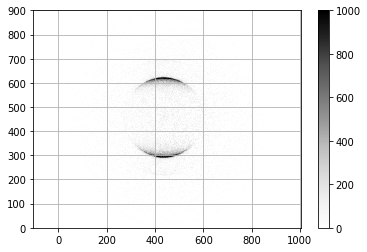

In [7]:
run = 177
filename = next(iglob(f"/data/TwoPulses/combined/Run_177-Run_177/PE_*.h5"))
saveas = "/data/results/PAC/afile.xlsx"

with File(filename, "r") as f:
    images = np.einsum('ijk->ikj', f["vmi/images"][...])

img = sum(images)
xn, yn = img.shape
xedges = np.arange(xn + 1)
yedges = np.arange(yn + 1)

plt.figure()
plt.pcolormesh(xedges, yedges, img.T, cmap="Greys")
plt.grid(True)
plt.axis("equal")
plt.colorbar()
plt.clim(0, 1000)
plt.show()

In [16]:
sigma = 4  # The factor of Gaussian filter
n = 5  # The number of beta parameters (including 0th)

# Below parameters for linear transform; Note that these are could be overwritten, after defining `mat` and `x0`!
x0, y0, th, k, m, ph = 440, 455, 0, 1, 0, 0
mat = mrot(ph) @ mrot(-th) @ mhorshear(m) @ msqueeze(k) @ mrot(th)
x0 = np.array([x0, y0])

zedges = np.arange(-400, 400 + 1)
redges, thedges = np.linspace(0, 400, 401), np.linspace(-np.pi, np.pi, 361)
dz = zedges[1:] - zedges[:-1]
r = (redges[1:] + redges[:-1]) / 2
roi = [  # Regions of interest
    [140, 180],
]


def analysis(img):
    img = gaussian_filter(img, sigma)
    xn, yn = img.shape
    xedges = np.arange(xn + 1)
    yedges = np.arange(yn + 1)
    f = interp(img, xedges, yedges)
    g = transpose_linearly(f, mat=mat, x0=x0)
    transformed = tohist(g, zedges, zedges)
    inverted = abel_inverse(transformed, zedges) * dz[None, :]  # shape: (r, z)
    sliced = interp(inverted, zedges, zedges)  # (rho, z) -> intensity
    hist_indrdomega = tohist(transpose_to_drdomega(sliced), redges, thedges)  # (r, th) -> intensity
    hist_indrdth = tohist(transpose_to_drdth(sliced), redges, thedges)  # (r, th) -> intensity
    coeff_neg, coeff_pos, _ = finite_legendre_transform_in_theta(
        hist_indrdomega.T, thedges, n,
    )  # Shapes of returns: (n, r) (n, r) (n, th)
    return {
        "dist": hist_indrdth.sum(1),
        **{f"beta{i}_neg": coeff_neg[i]/coeff_neg[0] for i in range(1, n)},
        **{f"beta{i}_pos": coeff_pos[i]/coeff_pos[0] for i in range(1, n)},
    }


def integrateit(fr=0, to=np.inf, dist=None, **d):
    if dist is None:
        return {}
    where = (fr < r) & (r < to)
    return {
        "dist": dist[where].sum(),
        **{k: np.average(d[k][where], weights=dist[where]) for k in d if k.startswith("beta")}
    }


def all_together(imgs):
    for i, img in enumerate(imgs):
        d = analysis(img)
        for fr, to in roi:
            yield {"nth": i, "fr": fr, "to": to, **integrateit(fr=fr, to=to, **d)}

In [18]:
df = pd.DataFrame(list(all_together(images)))
df = df[["nth", "fr", "to", "dist", *(k for k in df if k.startswith("beta"))]]
df.to_excel(saveas)
df

,nth,fr,to,dist,beta1_neg,beta1_pos,beta2_neg,beta2_pos,beta3_neg,beta3_pos,beta4_neg,beta4_pos
0,0,140,180,5.745310e+05,0.596863,0.662212,2.723664,4.481907,0.355851,0.627592,1.904450,2.495634
1,1,140,180,7.720943e+05,-0.070266,0.142181,2.827158,2.606831,-0.016608,-0.025361,1.594944,1.522513
2,2,140,180,6.316444e+05,-0.041449,0.078759,2.710181,2.795556,0.012930,0.105748,1.812611,1.645242
3,3,140,180,6.919353e+05,-0.077499,0.097613,2.624382,2.528223,0.063185,0.118154,1.729065,1.761553
4,4,140,180,8.263852e+05,-0.072294,0.044595,2.528973,2.383805,0.044537,0.084434,1.781563,1.644242
5,5,140,180,9.079996e+05,-0.125759,0.040401,2.520395,2.415531,0.004913,0.121754,1.785366,1.803655
6,6,140,180,5.052881e+05,-0.255458,0.057291,3.959713,3.346002,-0.767080,-0.392115,3.405650,2.750569
7,7,140,180,7.181850e+05,-0.108609,-0.102100,2.030798,1.789196,0.079596,0.146492,1.322794,1.079870
8,8,140,180,1.942060e+05,0.181123,0.546762,3.056555,4.801671,0.371875,-0.623027,2.617944,4.491771
9,9,140,180,1.050362e+06,-0.267629,-0.265869,1.391809,0.631259,0.147791,0.017399,0.611462,0.199612
